In [1]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 2449, done.
remote: Counting objects: 100% (2449/2449), done.
remote: Compressing objects: 100% (2044/2044), done.
remote: Total 2449 (delta 593), reused 1359 (delta 378), pack-reused 0
Receiving objects: 100% (2449/2449), 30.84 MiB | 38.38 MiB/s, done.
Resolving deltas: 100% (593/593), done.


In [2]:
# install the Object Detection API
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
     |████████████████████████████████| 9.0MB 19.9MB/s 
     |████████████████████████████████| 358kB 52.9MB/s 
     |████████████████████████████████| 1.1MB 46.1MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 829kB 44.0MB/s 
     |████████████████████████████████| 17.7MB 220kB/s 
     |████████████████████████████████| 153kB 54.7MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 2.2MB 54.5MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 
     |████████████████████████████████| 174kB 58.6MB/s 
     |████████████████████████████████| 1.2MB 45.7MB/s 
     |████████████████████████████████| 706kB 51.4MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 645kB 49.7MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 112kB 46.7MB/s 
  Created wheel fo

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

<a name='exercise-1'></a>
### **Exercise 1**: Import Object Detection API packages

Import the necessary modules from the `object_detection` package. 
- From the [utils](https://github.com/tensorflow/models/tree/master/research/object_detection/utils) package:
  - [label_map_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/label_map_util.py)
  - [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py): You'll use this to read model configurations from a .config file and then modify that configuration
  - [visualization_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py): please give this the alias `viz_utils`, as this is what will be used in some visualization code that is given to you later.
  - [colab_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/colab_utils.py)
- From the [builders](https://github.com/tensorflow/models/tree/master/research/object_detection/builders) package:
  - [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py): This builds your model according to the model configuration that you'll specify.

In [4]:
from object_detection.utils import label_map_util,config_util,colab_utils
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)


In [6]:
# uncomment the next 2 lines if you want to delete an existing zip and training directory
# !rm training-zombie.zip
# !rm -rf ./training

# download the images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip \
    -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2021-03-06 13:55:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.008s  

2021-03-06 13:55:57 (218 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



<a name='exercise-2'></a>

### **Exercise 2**: Visualize the training images

Next, you'll want to inspect the images that you just downloaded. 

* Please replace instances of `None` below to load and visualize the 5 training images. 
* You can inspect the *training* directory (using the `Files` button on the left side of this Colab) to see the filenames of the zombie images. The paths for the images will look like this:

```
./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg
```
- To set file paths, you'll use [os.path.join](https://www.geeksforgeeks.org/python-os-path-join-method/).  As an example, if you wanted to create the path './parent_folder/file_name1.txt', you could write: 

`os.path.join('parent_folder', 'file_name', str(1), '.txt')`

* You should see the 5 training images after running this cell. If not, please inspect your code, particularly the `image_path`.

In [7]:
os.path.join('/content/training','training-zombie'+str(1)+'.jpg')

'/content/training/training-zombie1.jpg'

In [ ]:
%matplotlib inline
train_images_np=[]
for i in range(1,6):
  path=os.path.join('/content/training','training-zombie'+str(i)+'.jpg')
  image=load_image_into_numpy_array(path)
  train_images_np.append(image)

for img in train_images_np:
  plt.figure()
  plt.imshow(img)


In [8]:
gt_boxes = []
colab_utils.annotate(train_images_np,gt_boxes)

<IPython.core.display.Javascript object>

In [ ]:
# Option 2: use given ground truth boxes
# set this to `True` if you want to override the boxes you drew
override = False

# bounding boxes for each of the 5 zombies found in each image. 
# you can use these instead of drawing the boxes yourself.
ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

# if gt_boxes is empty, use the reference
if not gt_boxes or override is True:
  gt_boxes = ref_gt_boxes

# if gt_boxes does not contain 5 box coordinates, use the reference 
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None)
    
    except:
      gt_boxes = ref_gt_boxes
      
      break


In [ ]:
gt_boxes

[array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
 array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
 array([[0.40833333, 0.18288394, 0.945     , 0.34818288]]),
 array([[0.16166667, 0.61899179, 0.8       , 0.91910903]]),
 array([[0.28833333, 0.12543962, 0.835     , 0.35052755]])]

<a name='exercise-3'></a>

### **Exercise 3**: Define the category index dictionary

You'll need to tell the model which integer class ID to assign to the 'zombie' category, and what 'name' to associate with that integer id.

- zombie_class_id: By convention, class ID integers start numbering from 1,2,3, onward.
  - If there is ever a 'background' class, it could be assigned the integer 0, but in this case, you're just predicting the one zombie class.
  - Since you are just predicting one class (zombie), please assign `1` to the zombie class ID.

- category_index: Please define the `category_index` dictionary, which will have the same structure as this:
```
{human_class_id : 
  {'id'  : human_class_id, 
   'name': 'human_so_far'}
}
```
  - Define `category_index` similar to the example dictionary above, except for zombies.
  - This will be used by the succeeding functions to know the class `id` and `name` of zombie images.

- num_classes: Since you are predicting one class, please assign `1` to the number of classes that the model will predict.
  - This will be used during data preprocessing and again when you configure the model.


In [ ]:
zombie_class_id=1
category_index={zombie_class_id:{
                'id':zombie_class_id,
                'name':'zombie'}}
num_classes = 1

category_index

{1: {'id': 1, 'name': 'zombie'}}

In [ ]:
label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


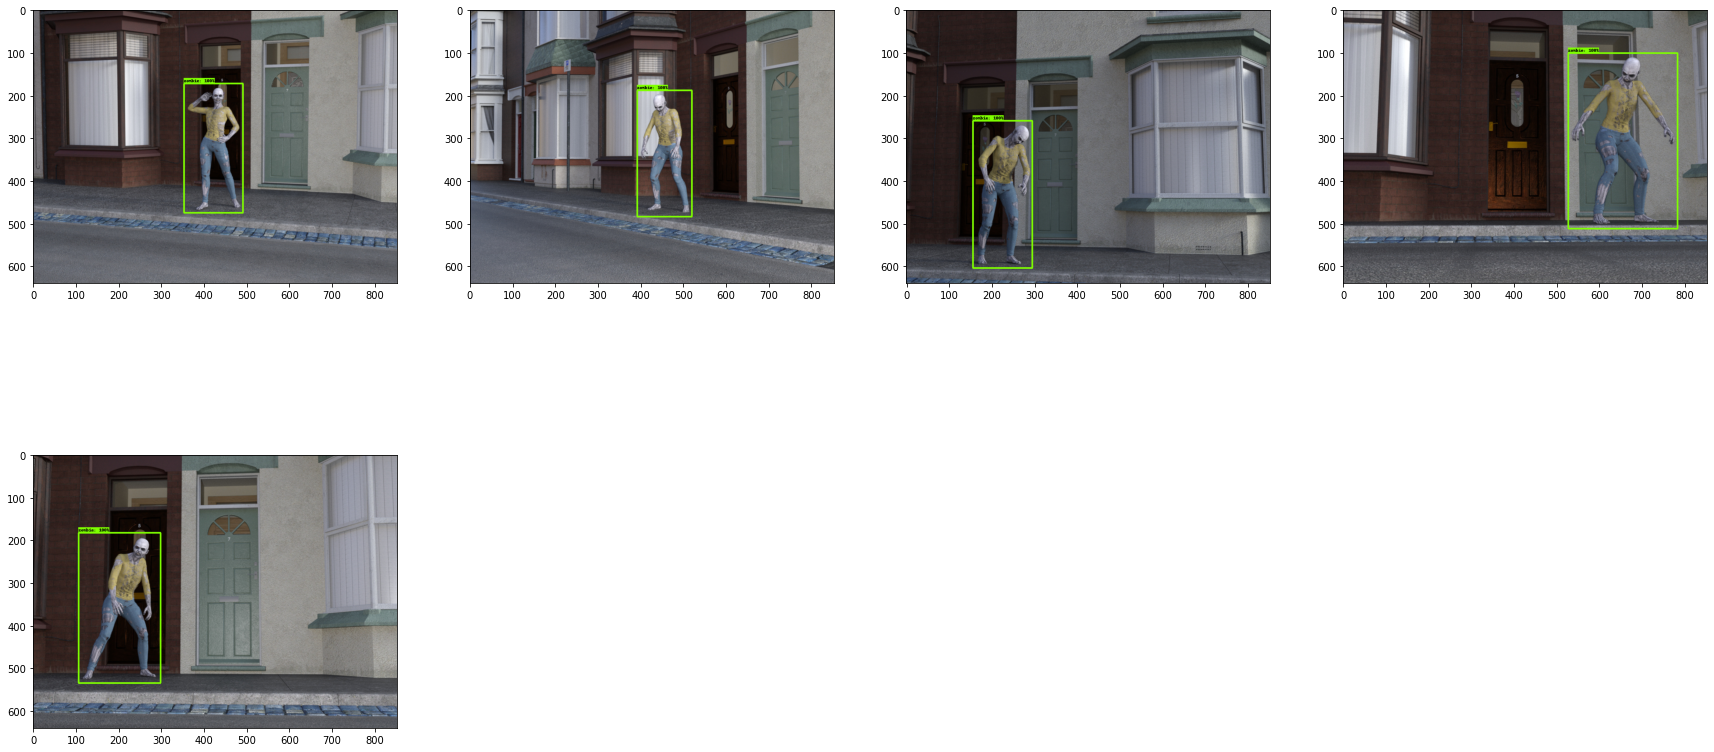

In [ ]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-01-19 12:40:47--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.189.128, 2404:6800:4008:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.189.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   254MB/s    in 0.9s    

2021-01-19 12:40:48 (254 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

In [ ]:
config=config_util.get_configs_from_pipeline_file(pipeline_config)
model_config=config['model']
model_config.ssd.num_classes=num_classes
model_config.ssd.freeze_batchnorm=True
detection_model=model_builder.build(model_config,is_training=True)

In [ ]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [ ]:
image,shapes=detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
pred_dict=detection_model.predict(image,shapes)
_=detection_model.postprocess(pred_dict,shapes)

In [ ]:
tmp_prediction_dict = detection_model.predict(image,shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict,shapes)

### END CODE HERE ###
print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_stp_function=get_model_step_function(detection_model,optimizer,to_fine_tune)


In [ ]:
g_images_list = train_image_tensors[0:2]

In [ ]:
g_preprocessed_image = detection_model.preprocess(g_images_list[0])


In [ ]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


In [ ]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


In [ ]:
# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)
# Calculate the loss after you've provided the ground truth 
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

Error message: 'list' object has no attribute 'get_shape'
keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background
Groundtruth tensor boxes has not been provided
loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.08500117
classification loss 1.15312386


In [ ]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

def get_model_step_function(model,optimizer,vars_to_fine_tune):
  @tf.function
  def train_step(image_tensors,
                 ground_truth_box,
                 ground_truth_class):
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(groundtruth_boxes_list=ground_truth_box,
        groundtruth_classes_list=ground_truth_class)
    with tf.GradientTape() as tape:
      preprocessed_image=tf.concat([detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors],axis=0)
      pred_loss=model.predict(preprocessed_image,shapes)
      loss_dict=model.loss(pred_loss,shapes)
      total_loss = loss_dict['Loss/localization_loss'] + loss_dict['Loss/classification_loss']
      gradient=tape.gradient(total_loss,vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradient,vars_to_fine_tune))
    return total_loss
  return train_step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_stp_function(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.1973279
batch 10 of 100, loss=17.60061
batch 20 of 100, loss=12.736561
batch 30 of 100, loss=1.0477134
batch 40 of 100, loss=0.056177042
batch 50 of 100, loss=0.030511057
batch 60 of 100, loss=0.0020686085
batch 70 of 100, loss=0.0007435711
batch 80 of 100, loss=0.0006279989
batch 90 of 100, loss=0.00051829976
Done fine-tuning!


In [ ]:
# uncomment if you want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

rm: cannot remove 'zombie-walk-frames.zip': No such file or directory
--2021-01-19 13:08:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M  25.1MB/s    in 3.6s    

2021-01-19 13:08:40 (25.1 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



In [ ]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/zombie-walk0000.jpg
./results/zombie-walk0001.jpg
./results/zombie-walk0002.jpg
./results/zombie-walk0003.jpg
./results/zombie-walk0004.jpg
./results/zombie-walk0005.jpg
./results/zombie-walk0006.jpg
./results/zombie-walk0007.jpg
./results/zombie-walk0008.jpg
./results/zombie-walk0009.jpg
./results/zombie-walk0010.jpg
./results/zombie-walk0011.jpg
./results/zombie-walk0012.jpg
./results/zombie-walk0013.jpg
./results/zombie-walk0014.jpg
./results/zombie-walk0015.jpg
./results/zombie-walk0016.jpg
./results/zombie-walk0017.jpg
./results/zombie-walk0018.jpg
./results/zombie-walk0019.jpg
./results/zombie-walk0020.jpg
./results/zombie-walk0021.jpg
./results/zombie-walk0022.jpg
./results/zombie-walk0023.jpg
./results/zombie-walk0024.jpg
./results/zombie-walk0025.jpg
./results/zombie-walk0026.jpg
./results/zombie-walk0027.jpg
./results/zombie-walk0028.jpg
./results/zombie-walk0029.jpg
./results/zombie-walk0030.jpg
./results/zombie-walk0031.jpg
./results/zombie-walk0032.jpg
./results/

In [ ]:
tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    detections=detection_model.postprocess(prediction_dict,shapes)
    return detections

KeyboardInterrupt: ignored

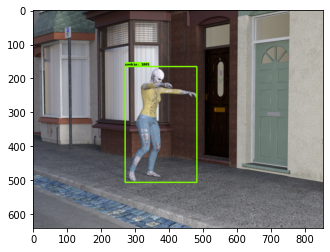

In [ ]:
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(6,8))
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

Frame 0


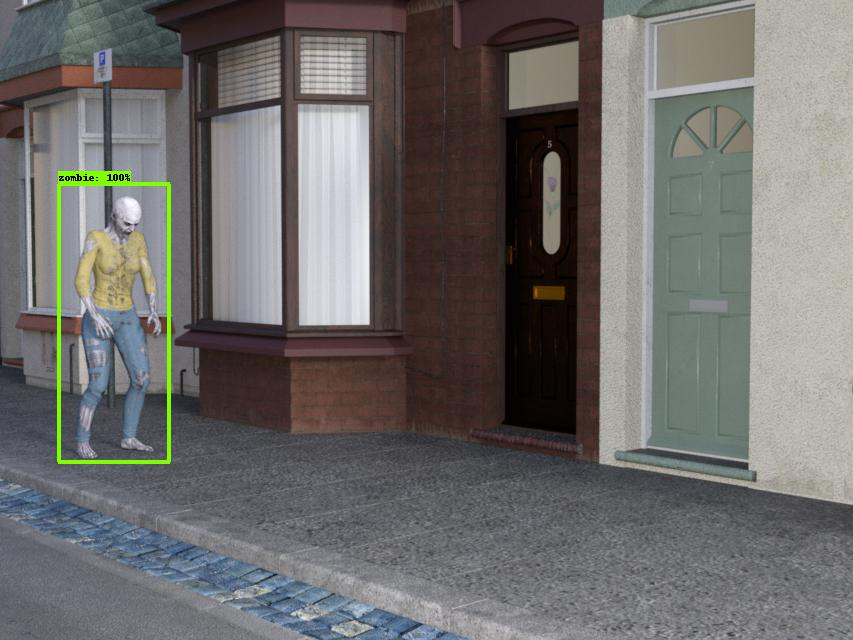


Frame 5


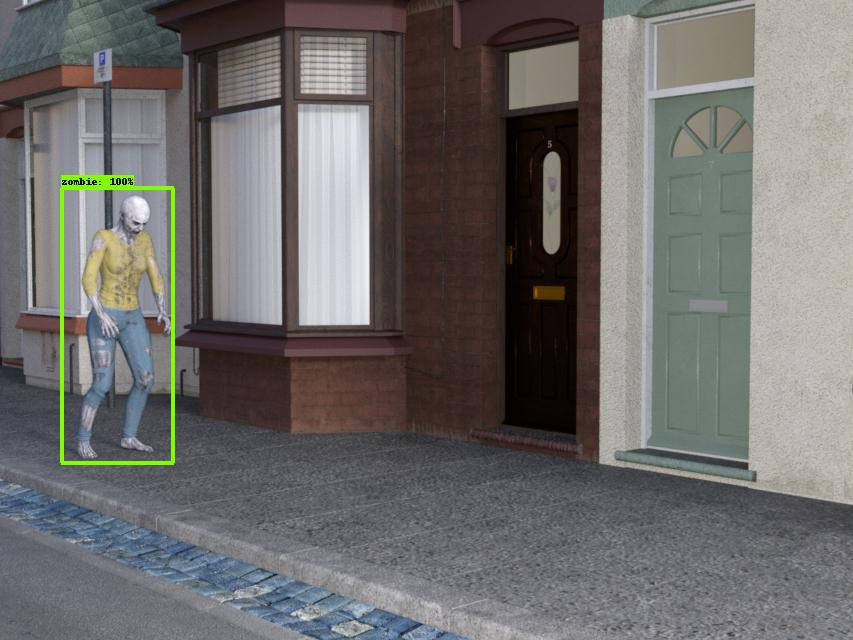


Frame 10


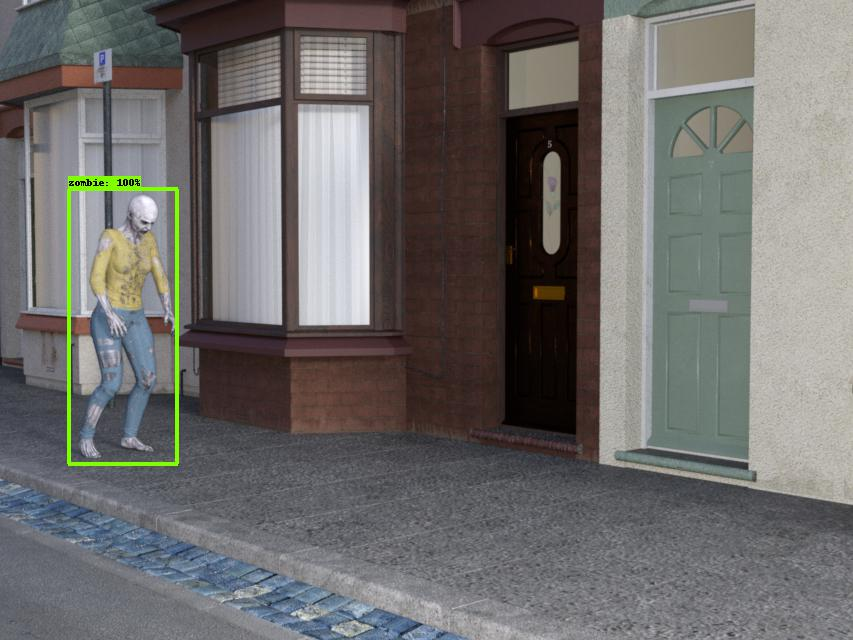

In [ ]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))